# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [21]:
# Load pickled data
import pickle

training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [22]:
#Summmary
n_train = len(X_train)

n_test = len(X_test)

image_shape = X_train[0].shape

n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


# Visualization 

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv
%matplotlib inline

In [24]:
signnames = []
with open('signnames.csv', 'r') as csvfile:
    namereader = csv.reader(csvfile, delimiter=',')
    next(namereader, None)
    for row in namereader:
        signnames.append(row[1])

In [25]:
def plot_signs(images, labels=None, rows=2, cols=4, rnd=True):

    nimg = rows*cols
    if rnd:
        selection = np.random.choice(images.shape[0], nimg, replace=False)
    else:
        selection = range(nimg)
        
    images_to_show = images[selection]
    
    f, axarr = plt.subplots(rows, cols, figsize=(12, 3*rows))
    for row in range(rows):
        for col in range(cols):
            index = (row*cols)+col
            ax = axarr[row,col] 
            ax.imshow(images_to_show[index])
            ax.axis('off')
            
            if labels is not None:
                label_id = labels[selection][index]
                ax.set_title('%s - %s' % (label_id, signnames[label_id]), fontsize=8)


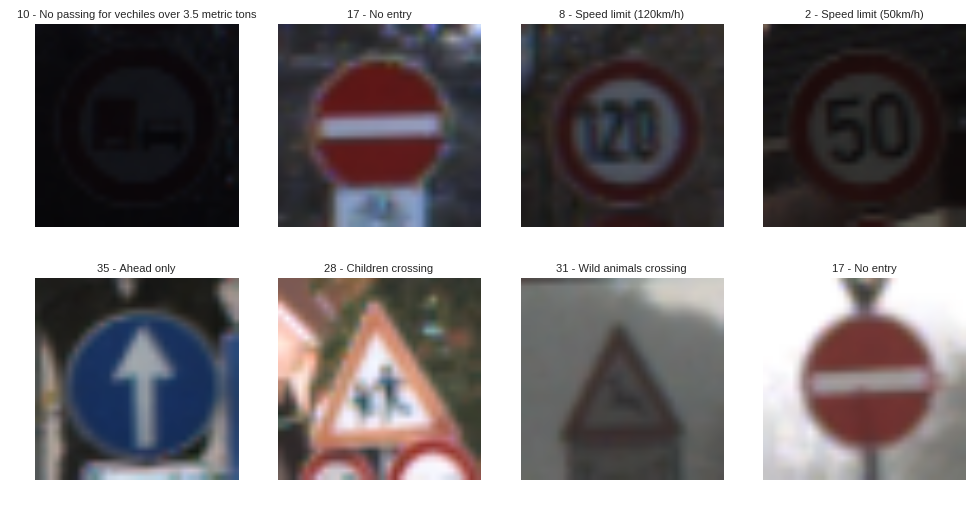

In [26]:
plot_signs(X_train, y_train)

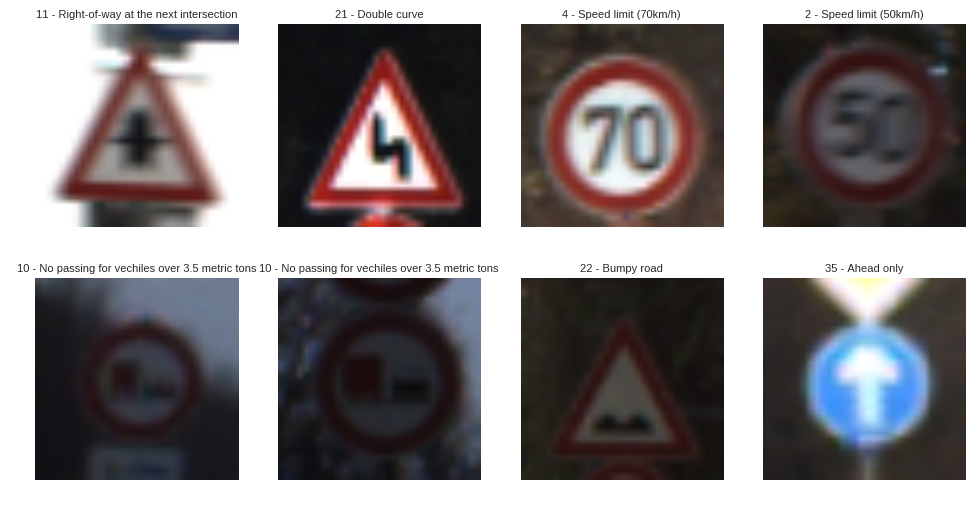

In [27]:
plot_signs(X_test, y_test)

### Class distribution

In [28]:
from collections import Counter
train_label_counter = Counter(y_train)

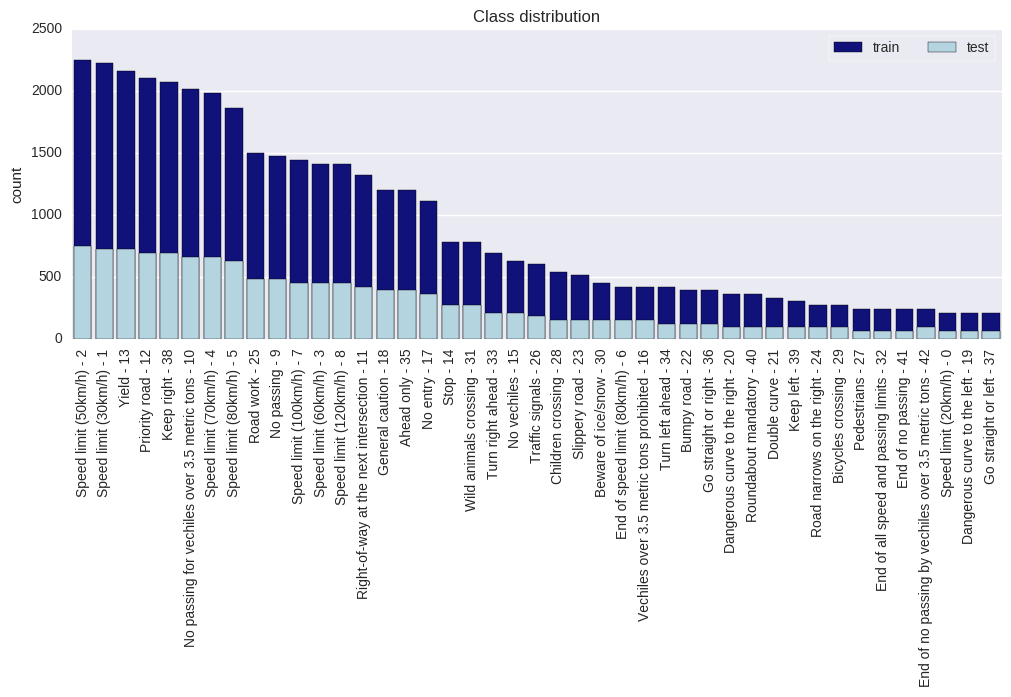

In [29]:
train_counter = Counter(y_train)
order = list(zip(*train_counter.most_common()))[0]

f, ax = plt.subplots(figsize=(12, 4))
ax = sns.countplot(x=y_train, order=order, color='darkblue', ax=ax, label="train")

ax = sns.countplot(x=y_test, order=order, color='lightblue', ax=ax, label="test")

_ = ax.set_title('Class distribution')
_ = ax.legend(ncol=2, loc="upper right", frameon=True)
_ = ax.set_xticklabels(['%s - %s'% (signnames[i], i) for i in order], rotation=90)

The distribution of the train and test set are very similar which is good but the classes them selfe are quite imbalanced. It might be possible to generate additional data by transforming images. For example images with the label "Turn right ahead" could be mirrored to become "Turn left ahead".

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

In [30]:
from sklearn import preprocessing
from sklearn.utils import shuffle
import tensorflow as tf
from tqdm import tqdm_notebook, tnrange
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import cv2
from scipy import stats

#### Preprocessing

In [31]:
def normalize(images, newMax=1., newMin=0., oldMax=255, oldMin=0):
    return (images - oldMin) * ((newMax - newMin)/(oldMax - oldMin)) + newMin

def standard_score(images):
    flattened = images.reshape(images.shape[0], -1)
    std = flattened.std(axis=1, keepdims=True)
    mean = flattened.mean(axis=1, keepdims=True)
    z_score = (flattened - mean)/std
    return z_score.reshape(images.shape)

def grayscale(images, kind='average'):
    if kind=='average':
        return np.mean(images, axis=3)
    
    if kind=='lightness':
        return (np.max(images, axis=3) + np.min(images, axis=3)) / 2
    
    if kind=='luminosity':
        return np.average(images, weights=[0.21, 0.72, 0.07], axis=3)

In [32]:
def preprocess_images(images):
    n = normalize(images) 
    return n

In [33]:
#One Hot Encoding
lb = preprocessing.LabelBinarizer()
lb.fit(y_train)

y_train_onehot = lb.transform(y_train)
y_test_onehot = lb.transform(y_test)

In [34]:
processed_X_train = preprocess_images(X_train)

# Split train data into a train and validation set
train_features, valid_features, train_labels, valid_labels = train_test_split(
    processed_X_train, 
    y_train_onehot,
    test_size=0.3,
    random_state=0)

train_all_features, train_all_labels = shuffle(processed_X_train, y_train_onehot, random_state=0)
valid_features, valid_labels = shuffle(valid_features, valid_labels, random_state=0)
train_features, train_labels = shuffle(train_features, train_labels, random_state=0)

train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)

valid_labels_cls = lb.inverse_transform(valid_labels)
train_labels_cls = lb.inverse_transform(train_labels)

test_features = preprocess_images(X_test)
test_labels = np.array(y_test_onehot)
test_labels_cls = lb.inverse_transform(test_labels)

#### Data generation

In [35]:
def random_transform(image, border):
    height = image.shape[0]
    width = image.shape[1]
    height_i = height - 1
    width_i = width - 1
    border_i = border + 1
    
    pts = np.array([np.random.randint(border_i, size=(2)),
                    [height_i, border_i] - np.random.randint(border_i, size=(2)),
                    [height_i, width_i] - np.random.randint(border_i, size=(2)),
                    [border_i, width_i] - np.random.randint(border_i, size=(2))],
                   dtype = "float32")

    dst = np.array([
        [0, 0],
        [31, 0],
        [31, 31],
        [0, 31]], dtype = "float32")


    trans = cv2.getPerspectiveTransform(pts, dst)
    warped = cv2.warpPerspective(image, trans, (height, width))

    return warped

In [36]:
def random_brightness(image, alpha=0.1):
    change_value = np.random.random()*2*alpha-alpha
    image = image + image * change_value
    image[image>1] = 1
    image[image<0] = 0
    return image

In [37]:
def create_variants(image, border, brightness_var):
    new_image = np.copy(image)
    warped = random_transform(new_image, border)
    return random_brightness(warped, brightness_var)

In [38]:
n_transforms = 5
border = 5
brightness_var = 0.3
image_variants = np.ndarray(shape=(train_features.shape[0]*n_transforms, *image_shape), dtype=float)
variants_labels = np.ndarray(shape=(train_features.shape[0]*n_transforms, n_classes), dtype=float)

for i, (image, cls) in enumerate(zip(train_features, train_labels)):
    start_i = i * n_transforms
    end_i = start_i + n_transforms
    image_variants[start_i:end_i] = np.array([create_variants(image, border, brightness_var)
                                              for i in range(n_transforms)])
    variants_labels[start_i:end_i] = cls

MemoryError: 

In [ ]:
plot_signs(train_features[3330:3345], rows=3, cols=5)

In [ ]:
add_image_variants = True
if add_image_variants:
    train_features = np.concatenate((train_features, image_variants), axis=0)
    train_labels = np.concatenate((train_labels, variants_labels), axis=0)

    train_features, train_labels = shuffle(train_features, train_labels, random_state=0)
    train_labels_cls = lb.inverse_transform(train_labels)

#### Network

##### Helper

In [ ]:
def plot_confusion_matrix(cls_pred, cls_act):
    cm = confusion_matrix(y_true=cls_act,
                          y_pred=cls_pred)

    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_title('Confusion Matrix', y=1.08)
    
    tick_marks = np.arange(n_classes)
    ax = sns.heatmap(cm, 
                     annot=True,
                     fmt='d',
                     cmap='Blues',
                     cbar_kws={"orientation": "horizontal"})
    ax.set_xticks(tick_marks, range(n_classes))
    ax.set_yticks(tick_marks, range(n_classes))
    ax.set_yticklabels(tick_marks[::-1], rotation=0)
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    
    plt.show()

In [ ]:
def update_performance_plot(fig, ax, x_vals, y_vals):
    for y, line in zip(y_vals, ax.lines):
        line.set_xdata(x_vals)
        line.set_ydata(y)
        
    if len(x_vals) > 0 and x_vals[-1] > ax.get_xlim()[1] - 100:
        ax.set_xlim(0, ax.get_xlim()[1] + 1000)
    
    fig.canvas.draw()
    
def init_performance_plot(labels, colors):
    figsize = (12, 4)
    fig, ax = plt.subplots(figsize=figsize)
    num_ticks = 6
    ax.set_title('Performance')
    ax.set_ylim([0, 1.0])
    ax.set_xlim([0, 1000])
    ax.set_xlabel('batches')
    
    [ax.plot([],[], color=c, label=l) for l, c in zip(labels, colors)]  
    ax.legend(loc=5)
    
    return (fig, ax)

In [ ]:
def plot_performance(batches, values, labels, colors):
    fig, ax = init_performance_plot(labels, colors)
    ax.set_xlim([0, batches[-1]])
    update_performance_plot(fig, ax, batches, values)
    plt.show()

In [ ]:
weights = []
biases = []


def create_weights(shape, mean=0.0, stddev=0.1):
    weight = tf.Variable(tf.truncated_normal(shape, mean=mean, stddev=stddev, dtype=tf.float32))
    weights.append(weight)
    return weight


def create_biases(length):
    bias = tf.Variable(tf.zeros([length], dtype=tf.float32))
    biases.append(bias)
    return bias


def create_conv_layer(input,
                      num_filters,
                      filter_size=[1,1],
                      strides=[1, 1, 1, 1],
                      padding='SAME',
                      relu=True,
                      is_training=None):

    num_input_channels = int(input.get_shape()[3]) 
    shape = [filter_size[0], filter_size[1], num_input_channels, num_filters]

    weights = create_weights(shape=shape)
    biases = create_biases(length=num_filters)

    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=strides,
                         padding=padding,
                         name='Convolution')

    layer = layer + biases
    
    if relu == True:
        layer = tf.nn.relu(layer)
    
    
    return layer


def create_fc_layer(input,
                    num_inputs,
                    num_outputs,
                    relu=True):

    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(length=num_outputs)
    layer = tf.matmul(input, weights, name='Fully_Connected') + biases
    
    if relu == True:
        layer = tf.nn.relu(layer)

    return layer
    

def create_inception_module(input, filters):
    branch1x1 = create_conv_layer(input, filters[0][0])

    branch5x5 = create_conv_layer(input, filters[1][0])
    branch5x5 = create_conv_layer(branch5x5, filters[1][1], [5, 5])

    branch3x3dbl = create_conv_layer(input, filters[2][0], [1, 1])
    branch3x3dbl = create_conv_layer(branch3x3dbl, filters[2][1], [3, 3])
    branch3x3dbl = create_conv_layer(branch3x3dbl, filters[2][2], [3, 3])

    branch_pool = tf.nn.avg_pool(input, [1,3, 3, 1], [1,1,1,1], 'SAME')
    branch_pool = create_conv_layer(branch_pool, filters[3][0], [1, 1])
    return tf.concat(3, [branch1x1, branch5x5, branch3x3dbl, branch_pool])


def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

#### Assembly

In [ ]:
learning_rate = 1e-3
batch_size = 256
epochs = 100

In [ ]:
features = tf.placeholder(dtype=tf.float32, shape=[None, *image_shape], name='features')

labels = tf.placeholder(dtype=tf.float32, shape=[None, n_classes], name='labels')
labels_cls = tf.argmax(labels, dimension=1)

phase_train = tf.placeholder(tf.bool,name='phase_train')
l2_lambda = tf.constant(0, dtype=tf.float32)


#Convolution Stage 1
with tf.name_scope('Dim_reduction'):
    layer = create_conv_layer(input=features,
                                    filter_size=[5,5],
                                    strides=[1,1,1,1],
                                    num_filters=64)
    layer = tf.nn.max_pool(value=layer,
                             ksize=[1, 3, 3, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME',
                             name='Pooling')

    
    layer = create_conv_layer(input=layer,
                                filter_size=[3,3],
                                num_filters=128)
    layer_pool2 = tf.nn.max_pool(value=layer,
                             ksize=[1, 3, 3, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME',
                             name='Pooling')

layer = create_inception_module(layer_pool2, [[32], [32, 64], [96, 128, 128], [32]])
layer = create_inception_module(layer, [[32], [32, 64], [96, 128, 128], [32]])

layer_concat = tf.concat(3, [tf.nn.dropout(layer, 0.2),
                             tf.nn.dropout(layer_pool2, 0.2)])

layer_pool4 = tf.nn.avg_pool(value=layer_concat,
                                 ksize=[1, 5, 5, 1],
                                 strides=[1, 1, 1, 1],
                                 padding='VALID',
                                 name='Avg_Pooling')


#Dropout
layer_dropout = tf.nn.dropout(layer_pool4, 0.5, name='Dropout')



layer_flat, num_features = flatten_layer(layer_dropout)


#Fully Connected
with tf.name_scope('Fully_Connected'):
    layer_fc = create_fc_layer(input=layer_flat,
                        num_inputs=num_features,
                        num_outputs=512,
                            relu=True)
    
    
    layer_fc = create_fc_layer(input=layer_fc,
                            num_inputs=512,
                            num_outputs=n_classes,
                                relu=False)

#Classification
with tf.name_scope('Classification'):
    pred = tf.nn.softmax(layer_fc)
    pred_cls = tf.argmax(pred, dimension=1)

    
with tf.name_scope('Analysis'):
    #Optimization
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc,
                                                            labels=labels)
    
    loss = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    
    #Measurement
    correct_prediction = tf.equal(pred_cls, labels_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
saver = tf.train.Saver()

#### Execution

In [ ]:
train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}
test_feed_dict = {features: test_features, labels: test_labels}

In [ ]:
def exceute_batch(x, y, tf_op, batch_size=512):
    batch_count = int(math.ceil(len(x)/batch_size))
    results = []
    for batch_i in range(batch_count):
        batch_start = batch_i*batch_size
        
        batch_features = x[batch_start:batch_start + batch_size]
        batch_labels = y[batch_start:batch_start + batch_size]

        feed_dict={features: batch_features, labels: batch_labels}               
        results[batch_start:batch_start + batch_size] = session.run(tf_op, feed_dict=feed_dict)

    return results

def get_batch_accuracy(x, y, y_cls, batch_size=512):
    preds = exceute_batch(x, y, pred_cls, batch_size)
    return accuracy_score(y_pred=preds, y_true=y_cls)

def get_batch_loss(x, y, batch_size=512):
    cross_entropies = exceute_batch(x, y, cross_entropy)
    return np.mean(cross_entropies)

def calculate_for_sample(x, y, tf_op, sample_size=1000):
    sample_size = min(x.shape[0], sample_size)
    sample_i = np.random.choice(x.shape[0], sample_size, replace=False)  
    
    sample_features = x[sample_i]
    sample_labels = y[sample_i]         
    
    feed_dict = {features: sample_features, labels: sample_labels}
    return session.run(tf_op, feed_dict=feed_dict)

In [ ]:
%matplotlib notebook

batch_count = int(math.ceil(len(train_features)/batch_size))

last_improvement = 0
patience = 6000
head_start = 10000
early_stopping = True
improvement_threshold = 0.995 

# Measurements use for graphing loss and accuracy
log_batch_step = 100
log_sample_size = 1000
batches = []
valid_loss_batch = []
train_loss_batch = []
valid_acc_batch = []
train_acc_batch = []
predictions = []
best_validation_loss = np.inf
logging = True

fig, ax = init_performance_plot(['Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'],
                               ['#FF9900', '#009999', '#FF0000', '#0000FF'])

with tf.Session() as session:
    session.run(tf.initialize_all_variables())   

    done_looping = False
    for epoch_i in range(epochs):
        if(done_looping):
            break
        
        # Progress barvalid_labels
        batches_pbar = tnrange(batch_count,
                               desc='Epoch %s/%s' % (epoch_i+1, epochs),
                               unit=' batches ',
                               leave=False,
                               smoothing=0.3)
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _ = session.run(optimizer, feed_dict={features: batch_features, labels: batch_labels})
            
            
            # Log
            if not batch_i % log_batch_step and logging:
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                
                val_loss, val_acc = calculate_for_sample(valid_features,
                                                         valid_labels,
                                                         [loss, accuracy],
                                                         sample_size=log_sample_size)
                valid_loss_batch.append(val_loss)
                valid_acc_batch.append(val_acc)                    
                    
                train_loss, train_acc = calculate_for_sample(train_features,
                                                             train_labels,
                                                             [loss, accuracy],
                                                             sample_size=log_sample_size)              
                train_loss_batch.append(train_loss)
                train_acc_batch.append(train_acc)
                
                update_performance_plot(fig, ax, batches, [train_loss_batch, valid_loss_batch, train_acc_batch, valid_acc_batch])
            
                total_iter = epoch_i * batch_count + batch_i
                #Early Stopping
                if total_iter > head_start:
                    if early_stopping and val_loss < best_validation_loss:

                        # improve patience if loss improvement is good enough
                        if val_loss < best_validation_loss * improvement_threshold:
                            last_improvement = total_iter
                            best_validation_loss = val_loss
                            saver.save(session, "tmp/model.ckpt")

                    if  early_stopping and total_iter - last_improvement > patience:
                        batches_pbar.write("Early Stopping. Best validation loss %s" % best_validation_loss)
                        done_looping = True                
                        break
    
    if not done_looping:
        saver.save(session, "tmp/model.ckpt")
        
    predictions = exceute_batch(valid_features, valid_labels, pred_cls)
    
%matplotlib inline

#### Measurement

In [ ]:
accuracy_score(y_pred=predictions, y_true=valid_labels_cls)

In [ ]:
plot_performance(batches,
                 [train_loss_batch, valid_loss_batch, train_acc_batch, valid_acc_batch],
                 ['Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'],
                 ['#FF9900', '#009999', '#FF0000', '#0000FF'])

In [ ]:
plot_confusion_matrix(predictions, valid_labels_cls)

In [ ]:
test_epochs = 10
predictions = []
retrain = False

with tf.Session() as session:
    
    if retrain:
        session.run(tf.initialize_all_variables())
        batch_count = int(math.ceil(len(train_all_features)/batch_size))

        for epoch_i in range(test_epochs):

            # Progress bar
            batches_pbar = tqdm_notebook(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, test_epochs), unit='batches')

            # The training cycle
            for batch_i in batches_pbar:
                batch_start = batch_i*batch_size
                batch_features = train_all_features[batch_start:batch_start + batch_size]
                batch_labels = train_all_labels[batch_start:batch_start + batch_size]

                # Run optimizer
                feed_dict = {features: batch_features, labels: batch_labels}
                _ = session.run(optimizer, feed_dict=feed_dict)
    else:
        saver.restore(session, "tmp/model.ckpt")
        
    pred_bar = tqdm_notebook(range(batch_count), desc='Making predictions', unit='batches')

    for batch_i in pred_bar:
        batch_start = batch_i*batch_size
        batch_end = min(batch_i + batch_size, test_labels.shape[0])
        batch_features = test_features[batch_start:batch_start + batch_size]
        batch_labels = test_labels[batch_start:batch_start + batch_size]
        feed_dict={features: batch_features, labels: batch_labels}
        predictions[batch_start:batch_start + batch_size] = session.run(pred_cls, feed_dict=feed_dict)


In [ ]:
accuracy_score(y_pred=predictions, y_true=test_labels_cls)

In [ ]:
plot_confusion_matrix(predictions, lb.inverse_transform(test_labels))

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [ ]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.